In [1]:
import matplotlib.pylab as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
from scipy import ndimage

### functions for loop size

In [2]:
def loop_size(t, v, delta, tau, x , taup):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (taup / (tau + taup)) * v * (t - (delta/2 / v)) * 2
        if t > (x*tau+(delta/2)/(v)):
            loop += (tau / (tau + taup)) * v * (t - (delta/2 / v) - tau*x) * 2
        return loop

def loop_size_static(t, v, delta, occupancy):
    if v * t <= delta/2:
        return v * t * 2
    else:
        loop = delta + (1-occupancy) * v * (t - (delta/2 / v)) * 2
        return loop

In [3]:
num_plot = 10
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

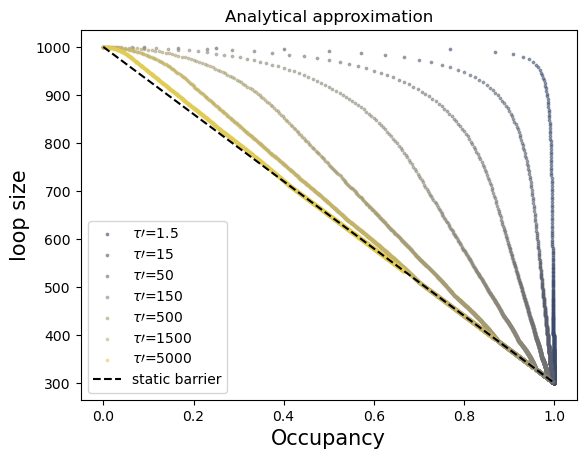

In [5]:
loop_for_high = []  # Renamed list to avoid conflict with function name
lifetime_range = [500]
taup_range = [1.5,15, 50, 150,500, 1500, 5000]
tau_range = np.arange(0,10000,5)
v_val_range = [1]
delta_val = 300
sep = 1000
i=1
sns.reset_defaults()
for v_val in v_val_range:
    for taup_val in taup_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                x_vals = np.linspace(0.1, 1, 10)
                loop_sizes = np.array([loop_size(lifetime, v_val, delta_val, tau_val, x, taup_val) for x in x_vals])
                integral = np.trapz(loop_sizes, x_vals)
                integral = np.mean(loop_sizes)
                loop_s.append([tau_val/(tau_val+taup_val), integral])
            loop_s = np.array(loop_s)
            plt.scatter(loop_s[:,0],loop_s[:,1],label=r'$\tau\prime$=%s'%(taup_val), s=3, alpha = 0.5, color= colors[i])

occupancy_range = np.arange(0,1.05,0.05)
lifetime_val = 500
loop_stat=[]
for occupancy_val in occupancy_range:
    loop_s = loop_size_static(lifetime_val,v=v_val,delta=delta_val,occupancy=occupancy_val)
    loop_stat.append([occupancy_val,loop_s])
loop_stat = np.array(loop_stat)
plt.plot(loop_stat[:,0],loop_stat[:,1],'--k',label='static barrier')
plt.title('Analytical approximation')
plt.ylabel('loop size', fontsize = 15)
plt.xlabel(r'Occupancy', fontsize = 15)
plt.legend()
plt.savefig('output/figures/analytical_for_loop_size.png')
plt.show()  


In [6]:
loop_for_high = []  
lifetime_range = [500,1500]
tau_range = [1, 1.5, 3, 5, 10, 15,  30, 50, 100, 150, 500, 1000, 1500, 5000, 10000, 15000,  150000]
taup_range = [ 1.0, 1.5, 3,  5.0, 10.0, 15, 30,   50, 100, 150, 500, 1500,  5000, 10000]

v_val_range = [1,3]
delta_val = 300
sep = 1000
i=1
file = open('../../data/loop_size_theoretical.csv','w')
file.write('lifetime,velocity,clife,cof,loopsize\n')
for vel in v_val_range:
    for taup_val in taup_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                x_vals = np.linspace(0.1, 1, 10)
                loop_sizes = np.array([loop_size(lifetime, vel, delta_val, tau_val, x, taup_val) for x in x_vals])
                integral = np.trapz(loop_sizes, x_vals)
                integral = np.mean(loop_sizes)
                file.write('%s,%s,%s,%s,%s\n'%(lifetime,vel,tau_val,taup_val,integral))
                loop_s.append([tau_val/(tau_val+taup_val), integral])
            loop_s = np.array(loop_s)
file.close()

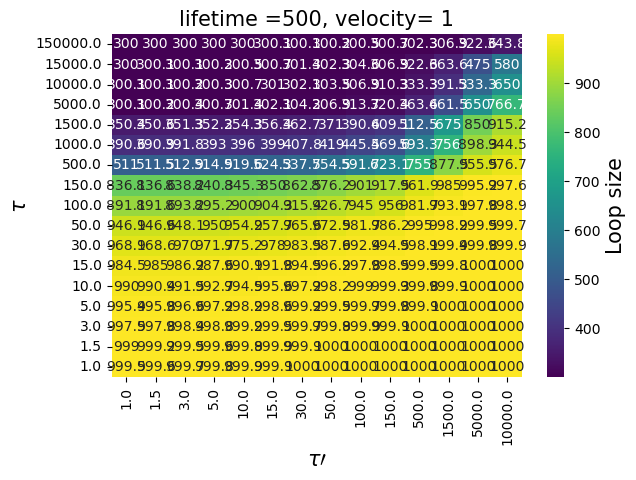

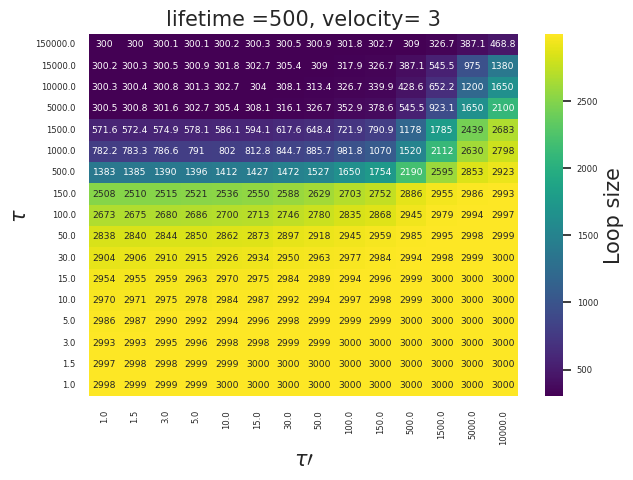

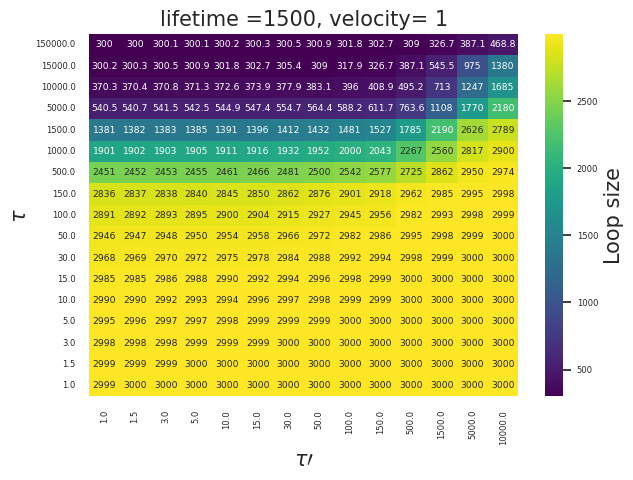

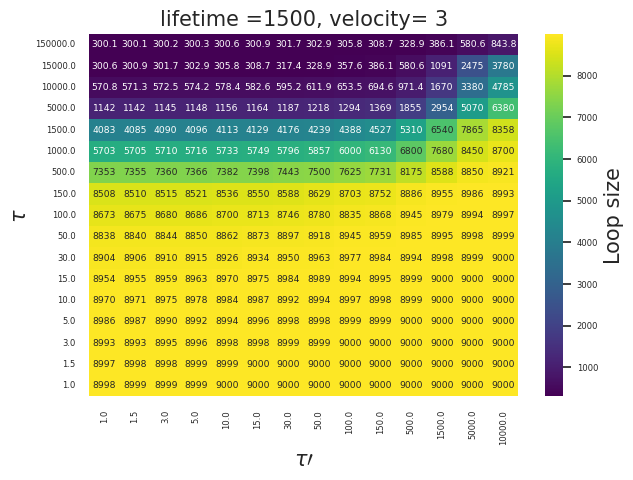

In [7]:
unique_vel = [ 1]

unique_life = [ 500]
#unique_sep = [100]
file = pd.read_csv('../../data/loop_size_theoretical.csv')
lifetime = file['lifetime']
velocity = file['velocity']
clife = file['clife']
cof = file['cof']

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)

c = 1

for life in list(unique_life):
    for vel in list(unique_vel):
        
        new_file = file[(lifetime == life) & (velocity == vel)][['clife', 'cof', 'loopsize']]
        #print(new_file)
        heatmap_data = new_file.pivot('clife', 'cof', 'loopsize')
        
        # Create the heatmap using seaborn
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis',  fmt='.4g', cbar_kws={'label': ' Loop size'})
        sns.set(font_scale=0.55)

        # Access the color bar object
        cbar = im.collections[0].colorbar
        
        # Set the font size of color bar label
        cbar.set_label('Loop size', fontsize=15)  # Adjust the font size as needed
        
        # Customize labels and title
        plt.xlabel(r'$\tau\prime$', fontsize=15)
        plt.ylabel(r'$\tau$', fontsize=15)
        plt.title('lifetime =%s, velocity= %s' % (life, vel),fontsize =15)
        plt.gca().invert_yaxis()
        
        c += 1


        plt.tight_layout()
        #plt.savefig('averaged_loop_size_life_%s_vel_%s_sep_%s.png'%(life,vel,sep))
        plt.show()

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6


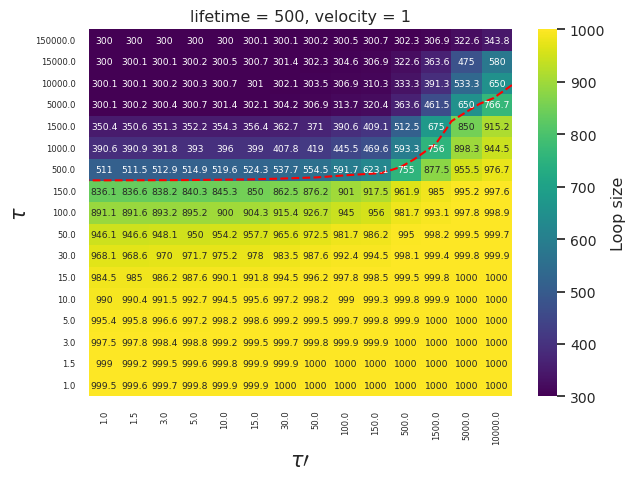

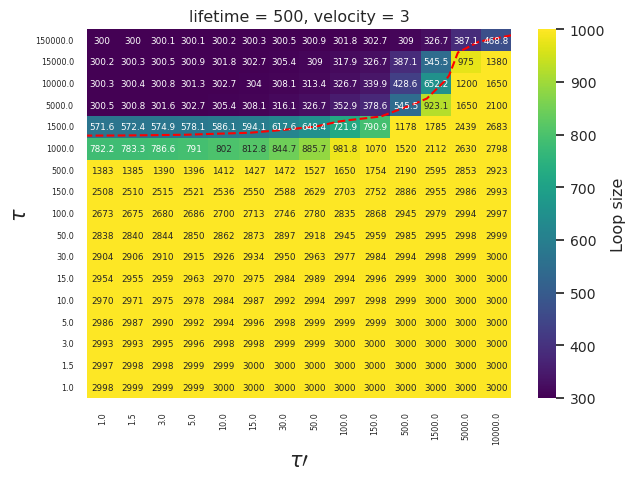

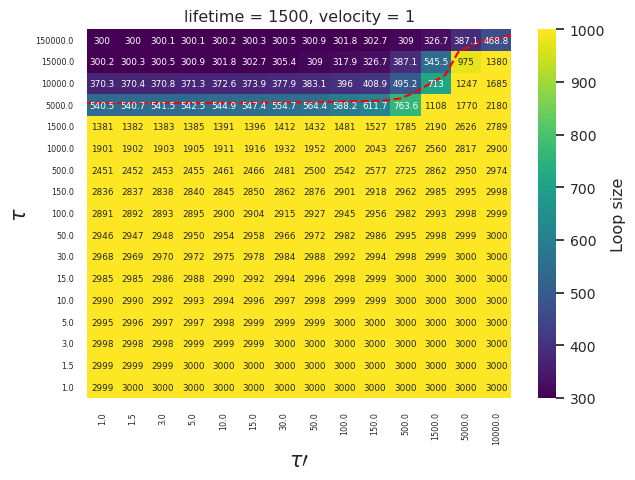

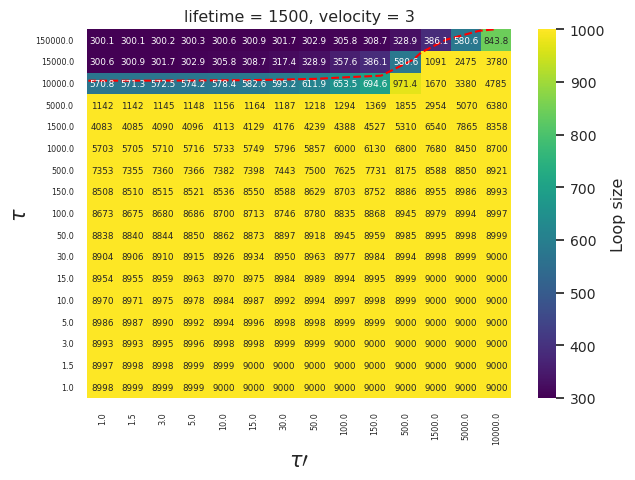

In [8]:
# Read the data from the CSV file
file = pd.read_csv('../../data/loop_size_theoretical.csv')

# Define unique values for lifetime and velocity
unique_life = np.unique(file['lifetime'])
unique_vel = np.unique(file['velocity'])

c = 1

for life in unique_life:
    for vel in unique_vel:
        # Filter the data based on lifetime and velocity
        new_file = file[(file['lifetime'] == life) & (file['velocity'] == vel)][['clife', 'cof', 'loopsize']]
        
        # Pivot the filtered data to create the heatmap data
        heatmap_data = new_file.pivot('clife', 'cof', 'loopsize')

        fig, ax = plt.subplots()

        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        ax = sns.heatmap(heatmap_data, annot=True, vmin = 300, vmax= 1000,cmap='viridis', fmt='.4g', cbar_kws={'label': 'Loop size'})
        sns.set(font_scale=0.53)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        # Set the font size of color bar label
        cbar.set_label('Loop size', fontsize=11.5)

        # Add equipotential lines for loop size = 700
        cntr = ax.contour(np.linspace(0, 14, 14*smooth_scale),
                           np.linspace(0, 17, 17*smooth_scale),
                           heatmap_data.to_numpy(), levels=[700], colors='red', linestyles='dashed') 
        
        # Customize labels and title
        plt.xlabel(r'$\tau\prime$', fontsize=15)
        plt.ylabel(r'$\tau$', fontsize=15)
        plt.title('lifetime = %s, velocity = %s' % (life, vel), fontsize=11.5)
        
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('output/figures/figtheoretical_map_loopsize_life_%s_vel_%s.png'%(life,vel),ppt= 500)
        plt.show()


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6


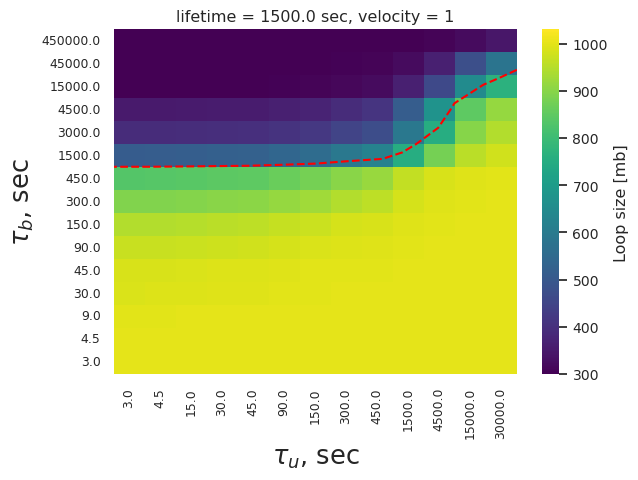

In [82]:
# Read the data from the CSV file
file = pd.read_csv('../../data/loop_size_theoretical.csv')

# Define unique values for lifetime and velocity
unique_life = [500]
unique_vel = [1]

c = 1
import matplotlib.ticker as tkr
tau_range = [1, 1.5, 3, 10, 15, 30, 50, 100, 150, 500, 1000, 1500,5000, 15000, 50000, 150000]
taup_range = [ 1.0, 1.5,  5.0, 10.0, 15,30,  50, 100, 150,500, 1500, 5000, 10000,15000]
file = file[file['clife'].isin(tau_range)]
file = file[file['cof'].isin(taup_range)]
convertor= 25*60/500
file['clife']=file['clife']*convertor
file['cof']=file['cof']*convertor
file['loopsize']=file['loopsize']
for life in unique_life:
    for vel in unique_vel:
        # Filter the data based on lifetime and velocity
        new_file = file[(file['lifetime'] == life) & (file['velocity'] == vel)][['clife', 'cof', 'loopsize']]
        
        # Pivot the filtered data to create the heatmap data
        heatmap_data = new_file.pivot('clife', 'cof', 'loopsize')

        fig, ax = plt.subplots()

        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        ax = sns.heatmap(heatmap_data, annot=False, vmin = 300, vmax= 1030,cmap='viridis', fmt='.4g', cbar_kws={'label': 'Loop size'})
        sns.set(font_scale=0.53)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        # Set the font size of color bar label
        cbar.set_label('Loop size [mb]', fontsize=11.5)

        # Add equipotential lines for loop size = 700
        number_tau = 13
        number_taup =15
        cntr = ax.contour(np.linspace(0, 13, 13*smooth_scale),
                           np.linspace(0, 15, 15*smooth_scale),
                           heatmap_data.to_numpy(), levels=[700], colors='red', linestyles='dashed') 
        
        # Customize labels and title
        plt.xticks(fontsize=8.91)
        plt.yticks(fontsize=8.91)
        plt.xlabel(r'$\tau_u$, sec', fontsize=18.5)
        plt.ylabel(r'$\tau_b$, sec', fontsize=18.5)
        plt.title('lifetime = %s sec, velocity = %s' % (life*convertor, vel), fontsize=11.5)
        
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('../../images/figtheoretical_map_loopsize_life_%s_vel_%s.pdf'%(life,vel),ppt= 500)
        plt.show()


In [8]:
lifetime_range = [500, 1500]
tau_range = [1, 1.5, 3, 5, 10, 15,  30, 50, 100, 150, 500, 1000, 1500, 5000, 10000, 15000,  150000]
taup_range = [ 1.0, 1.5, 3,  5.0, 10.0, 15, 30,   50, 100, 150, 500, 1500,  5000, 10000]
v_val_range = [1, 3]
delta_val = 300
sep = 1000
i=1
file = open('../../data/loop_size_theoretical.csv','w')
file.write('lifetime,velocity,clife,cof,loopsize\n')
for vel in v_val_range:
    for taup_val in taup_range:
        for lifetime in lifetime_range:
            i+=1
            loop_s = []
            for tau_val in tau_range:
                x_vals = np.linspace(0.1, 1, 10)
                loop_sizes = np.array([loop_size(lifetime, vel, delta_val, tau_val, x, taup_val) for x in x_vals])
                integral = np.trapz(loop_sizes, x_vals)
                integral = np.mean(loop_sizes)
                file.write('%s,%s,%s,%s,%s\n'%(lifetime,vel,tau_val,taup_val,integral))
                loop_s.append([tau_val/(tau_val+taup_val), integral])
            loop_s = np.array(loop_s)
file.close()

In [9]:
file = pd.read_csv('../../data/loop_size_theoretical.csv')

file
file = file[file['clife']!=500000]
lifetime = file['lifetime']
velocity = file['velocity']
clife = file['clife']
cof = file['cof']

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)


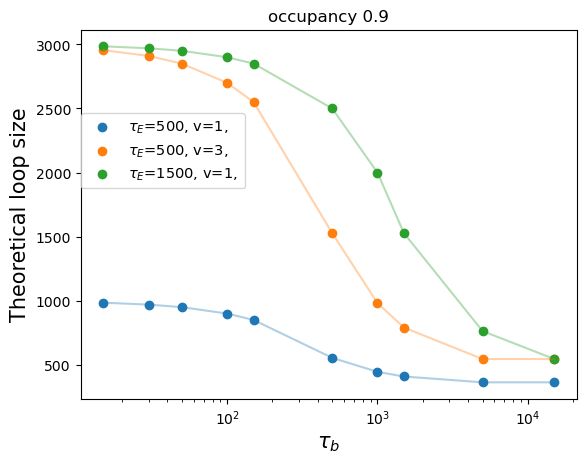

In [10]:
lifes, vels = [500, 1500] , [1, 3]

sns.reset_defaults()
for life in lifes:
    for vel in vels:
        if (life==1500 and vel==3): continue
        new_file = file[(lifetime == life)&(velocity == vel)&(clife == 10*cof)][['clife','cof', 'loopsize']]
        new_file_filtered = new_file.drop_duplicates(keep = 'first')
        new_file_filtered = new_file_filtered.sort_values('clife')
        new_clife = new_file_filtered['clife']
        frip_score = new_file_filtered['loopsize']
        plt.scatter(new_clife[1:], frip_score[1:], label=r'$\tau_E$=%s, v=%s, '%(life,vel))
        plt.plot(new_clife[1:], frip_score[1:], alpha = 0.35)

plt.xlim()
plt.title('occupancy 0.9')
plt.xscale('log')
plt.legend(fontsize = 10.51,loc = (0.001,0.57))
plt.ylabel('Theoretical loop size',fontsize = 15)
plt.xlabel(r'$\tau_b$', fontsize = 15)
#plt.savefig('../images/frip_for_tau.png')
plt.show()
        